<a href="https://colab.research.google.com/github/Nickguild1993/Natural_language_processing/blob/main/new_topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Updating topic clustering workflow

Using K-means to cluster responses around their respective centroids

Excellent holistic guide for colab functionality: https://www.tutorialspoint.com/google_colab/google_colab_quick_guide.htm

you'll need to set up your own api key, which you can do here: https://openai.com/api/

I put 5.00 down 6 months ago and have since run hundreds of calls and right now I'm at 4.58.

I use secrets manager to store my api key, here's a good resource on how to set that up: https://drlee.io/how-to-use-secrets-in-google-colab-for-api-key-protection-a-guide-for-openai-huggingface-and-c1ec9e1277e0

You'll need to !pip install openAI the first time you use it. Once you've done that, you can comment it out.



#### installing libraries and connecting to gdrive and api

In [1]:
# import libraries

###### remember to pip install openai ####
# !pip install openai
##########################################

import pandas as pd
import numpy as np
# visualizations
import matplotlib.pyplot as plt
import seaborn as sns
# model related
import openai
from openai import OpenAI
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import os
# using Counter for assessing "no particular reason" count in X open ended response
from collections import Counter

# kmeans - that's the clustering model
#  t-SNE (t-distributed Stochastic Neighbor Embedding) is great visualizing high-dimensional data, like your text embeddings, in a 2D or 3D space. This allows you to visually inspect the quality of your clusters.

In [2]:
# connect to gdrive

from google.colab import userdata
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# call API key
openai.api_key = os.getenv("nick_open_ai")
##### you'll need to replace this your api key

In [12]:
# the below code defines the ask format (that I've used for sentiment analysis, which will be later in the workflow but w/e).
# Can use it to verify the api key is connected, but the next cell with the try except error handling does the same thing!

# ################################################################################
# client = OpenAI(api_key = userdata.get('nick_open_ai')) # instantating client
#################################################################################


# completion = client.chat.completions.create( # completions is what chat returns and then creates that response based on the message/model
#     model="gpt-4o-mini",
#     messages=[
#         {"role": "system", "content": "You are a helpful subject matter expert in statistics and computer science."}, # sets the backgroun for gpt
#         {
#             "role": "user", # you're the user
#             "content": "Write a concise and accessible summary of what multimodal models are."
#         }
#     ]
# )

# print(completion.choices[0].message)

ChatCompletionMessage(content="Multimodal models are advanced artificial intelligence systems designed to process and analyze data from multiple types of modalities—such as text, images, audio, and video—simultaneously. These models leverage the strengths of each modality to enhance understanding and generate more comprehensive insights.\n\nFor instance, a multimodal model could analyze a video by interpreting the visual content alongside any spoken dialogue, allowing it to generate more accurate descriptions or respond to queries about the video's content. By integrating various forms of information, multimodal models can improve tasks like image captioning, video analysis, and sentiment detection, making them more versatile and effective in real-world applications.", refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None)


In [4]:
# try except error handling to determine if API key is active
client = OpenAI(api_key = userdata.get('nick_open_ai')) # instantating client

try:
    # Create an OpenAI client instance
    # The client automatically uses the OPENAI_API_KEY environment variable if it's set
    client

    # Make a simple, low-cost API call to list models
    client.models.list()

    print("Success! Your OpenAI API key is connected and working.")

except openai.AuthenticationError as e:
    print("[] AuthenticationError: Your API key is incorrect or has expired.")
    print("[x]  Please check API key and make sure it's stored correctly.")
    # print(f"   Error details: {e}") # Uncomment for more details
except Exception as e:
    print(f" An error occurred: {e}")
    print("   This could be a network issue or a problem with the OpenAI service.")


Success! Your OpenAI API key is connected and working.


###### reading in the excel file as the dataframe and cleaning it

In [5]:
# read in dataframe

df = pd.read_excel('/content/drive/MyDrive/Text_mining_projects/response_pull_6_24.xlsx')
df.head(5)

,Date Started,dirt_lizard_feelings,rocky_road_feelings,skeptical_lizard_feelings,"Now, please consider all three license plate designs together. For each question below, select the option that best fits the description.",dirt_lizard_FAVORITE_open_ended,rocky_road_FAVORITE_open_ended,skeptical_lizard_FAVORITE_open_ended,dirt_lizard_NOPE_open_ended,rocky_road_NOPE_open_ended,skeptical_lizard_NOPE_open_ended,"Considering the license plate you chose, how likely are each of the following messages to encourage you to buy it?Â",Which message would be the most likely to positively influence your decision to purchase this license plate?,Have you purchased a conservation license plate before?,What is your 5 digit zip code?,"If you would like to be notified which plate won, please provide your email address below."
0,2025-06-13,Very appealing,Moderately appealing,Very appealing,Which option do you like the most? = skeptical...,NaN,NaN,"As someone who love the Texas horned lizard, I...",NaN,I like more face then body,NaN,It would look great on my vehicle = Extremely ...,"I like horned lizards, or wildlife in general.",No,78537.0,km2842054@gmail.com
1,2025-06-13,Very appealing,Very appealing,Very appealing,Which option do you like the most? = dirt_lizard,Makes the best graphic design sense,NaN,NaN,NaN,NaN,NaN,It would look great on my vehicle = Extremely ...,"I like horned lizards, or wildlife in general.",No,75662.0,NaN
2,2025-06-13,Very appealing,Neither appealing or unappealing,Moderately appealing,Which option do you like the most? = dirt_liza...,"The close up onto the head, I think that the h...",NaN,NaN,NaN,No specific reason,NaN,It would look great on my vehicle = Somewhat l...,It benefits wildlife conservation efforts.,No,75092.0,Westonwcain@gmail.com
3,2025-06-13,NaN,NaN,NaN,Which option do you like the most? = skeptical...,NaN,NaN,Looks like it's taking on the world!,NaN,Position is awkward,NaN,It would look great on my vehicle = Somewhat l...,"I like horned lizards, or wildlife in general.",Yes,78247.0,Oobuck@rocketmail.com
4,2025-06-13,Very appealing,Very appealing,Moderately appealing,Which option do you like the most? = dirt_liza...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 ------------> FYI: RESPONDENTS WERE ASKED TO TYPE "NO SPECIFIC REASON" IF THEY DIDN'T HAVE ANYTHING SPECIFIC AS TO WHY THEY LIKED/DISLIKED "X" PLATE...USEFUL TO NUDGE FEEDBACK (BECAUSE THE HAVE TO TYPE SOMETHING, MIGHT AS WELL BE INSIGHTFUL).....HOWEVAHHHHH, THOSE RESPONSES SHOULDN'T BE CONSIDERED A CLUSTER SO NEED TO DROP EM <--------------------------------

In [6]:
# doing this as a trial run (6/24), the survey is running until the 30th, but I want to have the workflow ready
# meaning, the specifics of the following is meant to test instead of truly assess

df.rename(columns = {"dirt_lizard_FAVORITE_open_ended" : "dirt_lizard_fave"}, inplace = True)
print(df.columns)

Index(['Date Started', 'dirt_lizard_feelings', 'rocky_road_feelings',
       'skeptical_lizard_feelings',
       'Now, please consider all three license plate designs together. For each question below, select the option that best fits the description.',
       'dirt_lizard_fave', 'rocky_road_FAVORITE_open_ended',
       'skeptical_lizard_FAVORITE_open_ended', 'dirt_lizard_NOPE_open_ended',
       'rocky_road_NOPE_open_ended', 'skeptical_lizard_NOPE_open_ended',
       'Considering the license plate you chose, how likely are each of the following messages to encourage you to buy it?Â ',
       'Which message would be the most likely to positively influence your decision to purchase this license plate?',
       'Have you purchased a conservation license plate before?',
       'What is your 5 digit zip code?',
       'If you would like to be notified which plate won, please provide your email address below.'],
      dtype='object')


In [7]:
#checking NaN counts by column
df.isna().sum()

,0
Date Started,0
dirt_lizard_feelings,100
rocky_road_feelings,101
skeptical_lizard_feelings,105
"Now, please consider all three license plate designs together. For each question below, select the option that best fits the description.",19
dirt_lizard_fave,450
rocky_road_FAVORITE_open_ended,694
skeptical_lizard_FAVORITE_open_ended,708
dirt_lizard_NOPE_open_ended,741
rocky_road_NOPE_open_ended,508


In [8]:
# count the number of rows for column that are less than 10 characters to see if it makes sense to pop em

print(df[df['dirt_lizard_fave'].str.len() < 10].shape[0])
# print the responses to see if they should be thrown out
print(df[df['dirt_lizard_fave'].str.len() < 10]['dirt_lizard_fave'])
# Yeah, drop em

11
145         Cute
223          Nsr
347    Cute face
445        Cuter
470     Close up
472          eye
527           no
561          N/a
622       Clarty
645         Zoom
649           Nn
Name: dirt_lizard_fave, dtype: object


In [9]:
# name column as a variable

text_column = 'dirt_lizard_fave'

# Drop rows where the text column is empty/NaN
df.dropna(subset=["dirt_lizard_fave"], inplace=True)

# TESTING !!!!  You might want to filter out very short texts that are unlikely to be useful
df = df[df['dirt_lizard_fave'].str.len() > 10]

# Create a list of the text to be embedded
texts_to_embed = df['dirt_lizard_fave'].tolist()

print(f"Prepared {('dirt_lizard_fave')} texts for embedding.")


Prepared dirt_lizard_fave texts for embedding.


In [10]:
 ##################### CIRCLING BACK FROM CLUSTER INVESTIGATION ##############################################################################################
 ##########  IF THE RESPONDENT DIDN'T HAVE A RESPONSE, THEY WERE ASKED TO TYPE "NO PARTICULAR REASON"....THOSE RESPONSES SHOULDN'T BE A CLUSTER ##############
 #################### THEY SHOULD BE DROPPED BEFOREHAND ######################################################################################################

from collections import Counter
# count the frequency of "No particular reason"

# response_counts = Counter(df['dirt_lizard_fave'])

# sorted_counts = response_counts.most_common()

# for response, count in sorted_counts:
#   print(f'{response}: {count}')

In [11]:
 ##### REMOVING THE "NO SPECIFIC*** REASON" RESPONSES
 # b/c some folks used a "." at the end of that response, we need to use a "contains" method instead of a stricter "match" method

df = df[~df['dirt_lizard_fave'].str.contains('No specific reason')]

response_counts = Counter(df['dirt_lizard_fave'])

sorted_counts = response_counts.most_common()

#########################################################################################
 ###  the below loop is commented out b/c the result is a very lengthly output  #########
 ########################################################################################


# for response, count in sorted_counts:
#   print(f'{response}: {count}')



Next, send this list of texts to OpenAI's embedding model. (as of 6/24) We will use text-embedding-3-small, which is OpenAI's latest embedding model. The result will be a list of vectors (lists of numbers), which we'll plug into the dataframe as a new column: "embeddings"

In [12]:
embedding_model = 'text-embedding-3-small' # best choice as of 6/24

# Create a list of the text to be embedded *after* dropping rows
texts_to_embed = df['dirt_lizard_fave'].tolist()

# call the OpenAI embedding API, name response
response = client.embeddings.create(
    input = texts_to_embed,
    model = embedding_model
)

# Extract the embedding data from the response
embeddings = [data.embedding for data in response.data]

# add the embeddings to the df
df["embeddings"] = embeddings

print('Embeddings generated and appended onto the df')
# if you check the df here it'll look fucked, so check in the next cell if needed

Embeddings generated and appended onto the df


In [30]:
# df.head(3)

###### using scikit-learn to cluster and analyze - elbow method :)

Running elbow method to find the optimal cluster count...


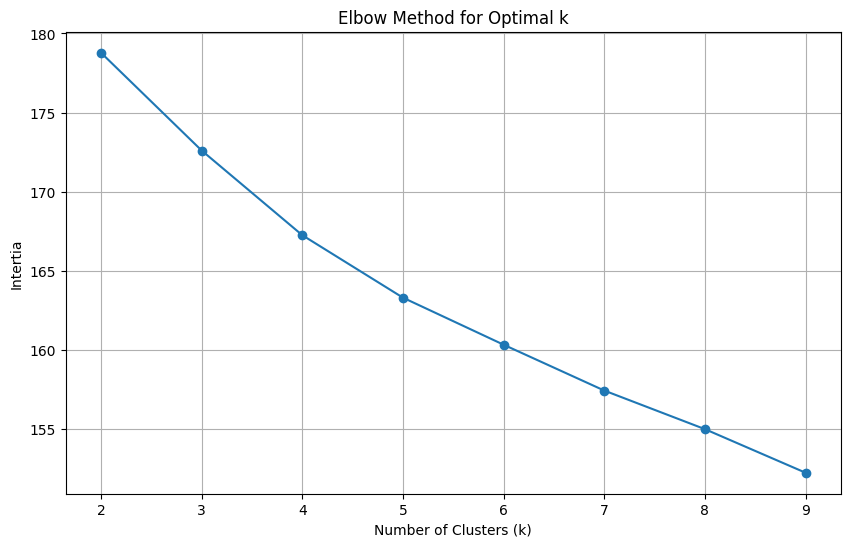

In [13]:
# conver the "embeddings" column to a format that scikit-learn can use
# which is, 2d numpy array with each row : embedding

# used X as variable name since its normally used to denote feature data in ML
X = np.array(df["embeddings"].tolist())

# elbow method, need to test clusters
k_range = range(2,10)
intertia_values = [] # create an empty list to store the score that K-means calculates for each value of "k". Holds results after loop

# check the cluster range to find the best
print('Running elbow method to find the optimal cluster count...')

for k in k_range:                                                               # n_init = 10 is the number of iterations to run from scratch and keep the best one out of those 10.
  kmeans = KMeans(n_clusters = k, init='k-means++', n_init=10, random_state = 13)       # FYI: 'k-means++' is a "smart" method for choosing initial cluster start points vis-a-vis RNG
  kmeans.fit(X)                                                                     # runs the K-means on the data (X). finds the best centroids for the "k" clusters and assigns the embeddings to their respective cluster. TRAINING
  intertia_values.append(kmeans.inertia_)                                         # score is "interia". this retrieves that score and appends it to the interia_values list
                                                            # additional info: interia is the metric for evaluating the elbow method. measures the sum of squared distances to their closest centroid.
                                                              #  i.e., how compact and internally coherent is a cluser- LOWER SCORE = BETTER
# plot the results
plt.figure(figsize = (10,6))
plt.plot(k_range, intertia_values, marker = 'o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Intertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.grid(True)
plt.show()

##### Apply the ideal (or assumed, at least) number of clusters to the kmeans algo -> UPDATE: the model (seems) to have made 2 clusters, one for horned *lizard* and another for horned *toad* b/c people called it different things.

UPDATE PART 2: I TIRE OF GIVING THE "NLP SME AGENT" DIFFERENT RULES TO STOP IT FROM CREATING TWO SEPARATE CLUSTERS FOR "HORNED LIZARD". INSTEAD WE'RE REDUCING "OPTIMAL_K" TO 4 (DOWN FROM 5)

In [14]:
# based on the elbow method chart, it looks like it's either 5 or 6 clusters : UPDATE --> horned lizard and horned frog...4 clusters not 5

# set optimal_k
optimal_k = 5

# just in case, set the data as a numpy array (it's above but in case something changes in the code block)
X = np.array(df["embeddings"].tolist())

print(f'Running K-means w/ k = {optimal_k} clusters....')

# initialize the model with the # of clusters chosen
kmeans = KMeans(
    n_clusters = optimal_k,
    init = 'k-means++',
    n_init = 10,
    random_state = 13
)

# run it, boys
kmeans.fit(X)

# Assign da labels back to the DF
# FYI: .labels_ --> contains the cluster number that the row of text (customer response) is paired with
df['cluster'] = kmeans.labels_

print("inshallah alhamduliah, cluster mapping complete")

Running K-means w/ k = 5 clusters....
inshallah alhamduliah, cluster mapping complete


Checking the results of da clustering

In [15]:
# check the dataframe real quick
df.head(3)

,Date Started,dirt_lizard_feelings,rocky_road_feelings,skeptical_lizard_feelings,"Now, please consider all three license plate designs together. For each question below, select the option that best fits the description.",dirt_lizard_fave,rocky_road_FAVORITE_open_ended,skeptical_lizard_FAVORITE_open_ended,dirt_lizard_NOPE_open_ended,rocky_road_NOPE_open_ended,skeptical_lizard_NOPE_open_ended,"Considering the license plate you chose, how likely are each of the following messages to encourage you to buy it?Â",Which message would be the most likely to positively influence your decision to purchase this license plate?,Have you purchased a conservation license plate before?,What is your 5 digit zip code?,"If you would like to be notified which plate won, please provide your email address below.",embeddings,cluster
1,2025-06-13,Very appealing,Very appealing,Very appealing,Which option do you like the most? = dirt_lizard,Makes the best graphic design sense,NaN,NaN,NaN,NaN,NaN,It would look great on my vehicle = Extremely ...,"I like horned lizards, or wildlife in general.",No,75662.0,NaN,"[0.01445708703249693, 0.025883730500936508, -0...",0
2,2025-06-13,Very appealing,Neither appealing or unappealing,Moderately appealing,Which option do you like the most? = dirt_liza...,"The close up onto the head, I think that the h...",NaN,NaN,NaN,No specific reason,NaN,It would look great on my vehicle = Somewhat l...,It benefits wildlife conservation efforts.,No,75092.0,Westonwcain@gmail.com,"[0.08200854063034058, -0.0009361402480863035, ...",3
5,2025-06-13,Very appealing,Moderately appealing,Neither appealing or unappealing,Which option do you like the most? = dirt_liza...,Details are spot on. Features show up better i...,NaN,NaN,NaN,Looks fake and his legs look weird. Not propor...,NaN,It would look great on my vehicle = Extremely ...,"I like horned lizards, or wildlife in general.",No,78666.0,lgsamo@aol.com,"[0.001361220027320087, 0.012054603546857834, 0...",4


In [16]:
# ############################## CHECKING THE CLUSTER SIZES --> If we have 1 cluster with only a few attached responses, then that cluster might be unnecessary ####################

print(f"Distribution of responses amongst the {optimal_k} clusters is:")
print(df['cluster'].value_counts().sort_index())

Distribution of responses amongst the 5 clusters is:
cluster
0    60
1    90
2    66
3    46
4    35
Name: count, dtype: int64


In [17]:
print('Analyzing responses from each cluster')
for i in range(optimal_k):
  print(f"Cluster {i}  (size: {df[df['cluster'] == i].shape[0]})")
  sample_responses = df[df['cluster'] == i]['dirt_lizard_fave'].head(5).tolist()
  for response in sample_responses:
    print(f' {response[:75]}...')

Analyzing responses from each cluster
Cluster 0  (size: 60)
 Makes the best graphic design sense...
 Colors, shape and angle are spot on!...
 It is the most iconic...
 Composition...
 The K in Keep is overlapped by the image. Looks like 'eep' Texas Wild....
Cluster 1  (size: 90)
 I like the clear eye! Looks like he's looking at you....
 Angle of the head. The head in other photos looks cropped even if it isn't....
 Close up and bright eyes...
 You can see more up close details.  I like the way he or she is looking at ...
 Sweet face, open eyes, clarity of the photo, the posing is nice...
Cluster 2  (size: 66)
 I can see the lizard clearly and in detail. Also the color of the sand goes...
 Close up, the lizard looks alert and typical...
 I like the profile of the horned lizard the best. It's a good close up that...
 you see both the lizard and license plate numbers. lizard isn't lost in the...
 I think the lizard looks very regal...
Cluster 3  (size: 46)
 The close up onto the head, I t

##### LET'S TURN THOSE CONTEXTUALLY MEANINGLESS CLUSTER NUMBERS INTO KEYWORDS

In [18]:
# already established the column & the number of clusters so I don't need to rewrite that
text_column_name = 'dirt_lizard_fave' # doing this so it's not hardcoded


In [19]:


def get_cluster_keyword(texts, model="gpt-4o"):
    """
    Uses OpenAI's Chat API to generate a single keyword for a list of texts.

    """
    # ---
    # Join all texts from the list.
    # ----
    combined_responses = "\n".join(texts)

    prompt = f"""
    Analyze the following texts from a topic cluster.
    Your task is to provide a single, concise keyword or a 2-word phrase that best summarizes the central theme, the name of the animal, whether they refer to it as a horned lizard, horned frog, or horned toad, is not a cluster.  the clusters should be descriptions.

    RULES:
    1.  Respond with the keyword/phrase ONLY.
    2.  Do not provide any explanation, preamble, or punctuation like quotes.
    3.  The keyword should be lowercase.
    4.  Respondents used different terms, e.g., horned frog, horned toad, horned lizard to describe the same animal. For the purpose of this analysis, consider those different iterations as the same animal.

    --- THE TEXT TO BE EXAMINED ---
    {combined_responses}
    --- END OF TEXT TO BE EXAMINED ---

    Based on the rules, what is the single summary keyword or phrase?
    """

    try:
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": "You are a subject matter expert in text analysis and summarization."},
                {"role": "user", "content": prompt}
            ],
            temperature=0,
            max_tokens=10
        )
        keyword = response.choices[0].message.content.strip().replace('"', '')
        return keyword
    except Exception as e:
        # This is important for debugging if a cluster is too large for the openAI API
        print(f"GDI an error occurred: {e}")
        return "error"

# --- Main loop  ---

cluster_keywords = {}

print("Generating keywords for each cluster...")   # NOTE: THE OPTIMAL_K REFERS TO THE INTREPRETTED BEST NUMBER OF CLUSTERS FROM THE ELBOW PLOT
for i in range(optimal_k):
    # Get all responses belonging to the current cluster
    cluster_texts = df[df['cluster'] == i][text_column_name].tolist()

    if not cluster_texts:
        print(f"Cluster {i}: Skipping (no texts found)")
        continue

    # Generate the keyword using all responses in the cluster
    keyword = get_cluster_keyword(cluster_texts)

    cluster_keywords[i] = keyword
    print(f"Cluster {i}: {keyword}")

print("\n Yuhhhhhh keyword generation complete!")
print("Generated keywords:", cluster_keywords)

# --- Apply keywords back to the df ---
df['topic_keyword'] = df['cluster'].map(cluster_keywords)

print("\nDataFrame with final topic keywords:")
print(df[[text_column_name, 'cluster', 'topic_keyword']].head())

Generating keywords for each cluster...
Cluster 0: visual clarity
Cluster 1: close-up profile
Cluster 2: close-up detail
Cluster 3: horn visibility
Cluster 4: detail focus

 Yuhhhhhh keyword generation complete!
Generated keywords: {0: 'visual clarity', 1: 'close-up profile', 2: 'close-up detail', 3: 'horn visibility', 4: 'detail focus'}

DataFrame with final topic keywords:
                                    dirt_lizard_fave  cluster  \
1                Makes the best graphic design sense        0   
2  The close up onto the head, I think that the h...        3   
5  Details are spot on. Features show up better i...        4   
8  I like the clear eye! Looks like he's looking ...        1   
9  Angle of the head. The head in other photos lo...        1   

      topic_keyword  
1    visual clarity  
2   horn visibility  
5      detail focus  
8  close-up profile  
9  close-up profile  


In [20]:
# let's look at the responses within X cluster

# select all rows with topic_cluster = "close up"

topic_cluster_keyword = 'visual clarity'

df_cluster_eval = df[df['topic_keyword'].str.contains(topic_cluster_keyword)]

df_cluster_eval[['dirt_lizard_fave', 'topic_keyword']]

,dirt_lizard_fave,topic_keyword
1,Makes the best graphic design sense,visual clarity
47,"Colors, shape and angle are spot on!",visual clarity
61,It is the most iconic,visual clarity
72,Composition,visual clarity
73,The K in Keep is overlapped by the image. Look...,visual clarity
94,Like the picture,visual clarity
99,He's literally just a baby,visual clarity
110,good balance,visual clarity
114,Straight forward and a good representation,visual clarity
152,You can see the animal,visual clarity
